# ДЗ №5

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd 

from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt

### 1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями

In [2]:
data = pd.read_csv('my_BRENT2019.csv', sep = ',', index_col=[0], parse_dates=[0])

In [3]:
data['diff'] = data['Значение'].diff()
data['diff'].fillna(0, inplace=True)

### 2. Добавьте первые разности по стоимости доллара и евро к рублю

In [4]:
rub_doll=pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx')
rub_doll.index = pd.to_datetime(rub_doll['data'].values).date
rub_doll.drop(['nominal','cdx','data'], axis=1,inplace = True)
df = data.merge(rub_doll, left_index=True, right_index=True)
df['diff_rub_usd'] = df['curs'].diff()
df['diff_rub_usd'].fillna(0, inplace=True)
df.drop("curs", axis=1, inplace=True)

rub_e=pd.read_excel('R_E01_09_2010_T01_09_2019.xlsx')
rub_e.index = pd.to_datetime(rub_e['data'].values).date
rub_e.drop(['nominal','cdx','data'], axis=1,inplace = True)
df = df.merge(rub_e, left_index=True, right_index=True)
df['diff_rub_eur'] = df['curs'].diff()
df['diff_rub_eur'].fillna(0, inplace=True)
df.drop("curs", axis=1, inplace=True)

df.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,diff,diff_rub_usd,diff_rub_eur
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0,0.00,0.0000,0.0000
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0,0.52,-0.0668,0.1527
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0,-0.32,-0.1143,0.1247
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0,0.05,0.0064,0.0604
2010-09-07,77.26,2010,9,7,3,250,36,1,0,0,1,0.39,-0.1151,0.1215


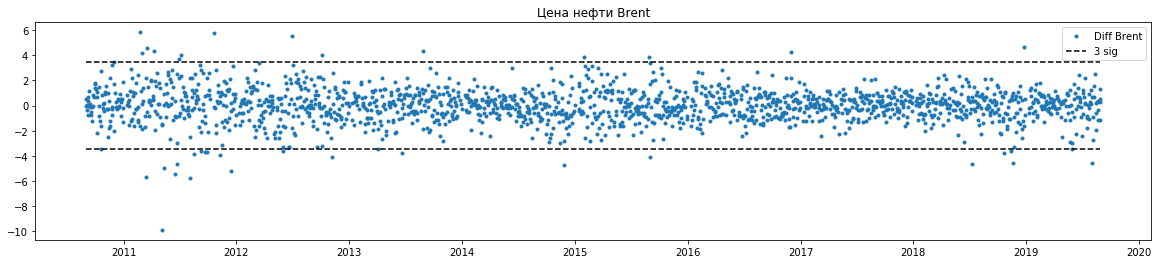

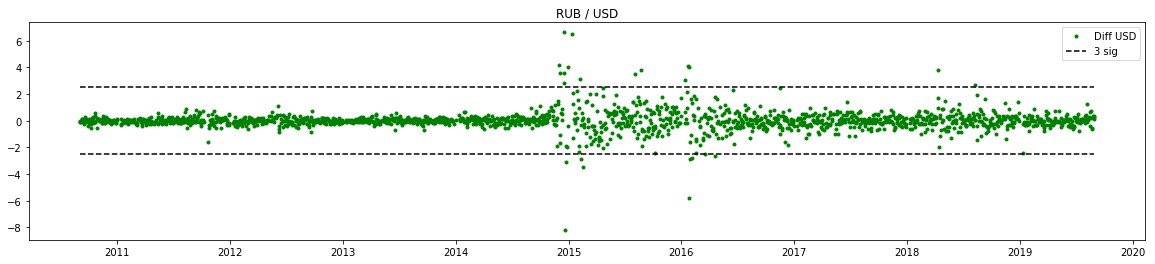

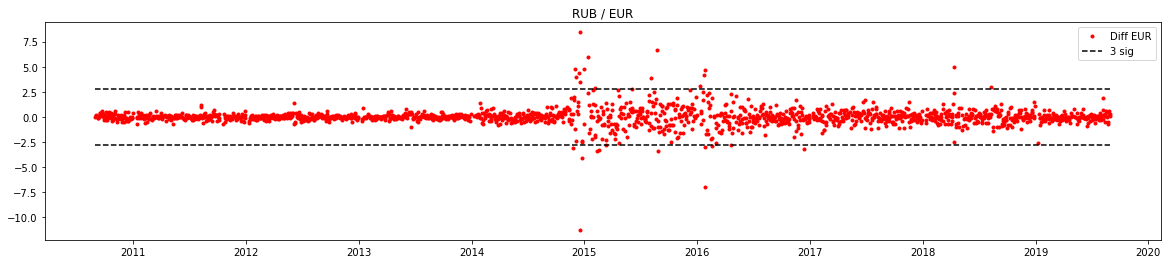

In [5]:
s_brent = np.std(df['diff'])**0.5*3
s_usd = np.std(df['diff_rub_usd'])**0.5*3
s_eur = np.std(df['diff_rub_eur'])**0.5*3

plt.figure(figsize=(20,4))
plt.plot(df.index, df['diff'],'.', label='Diff Brent')
plt.plot(df.iloc[[0,-1]].index,[s_brent, s_brent],'--k',label ='3 sig')
plt.plot(df.iloc[[0,-1]].index,[-s_brent, -s_brent],'--k')
plt.legend()
plt.title('Цена нефти Brent')
plt.show()

plt.figure(figsize=(20,4))
plt.plot(df.index, df['diff_rub_usd'],'.g', label='Diff USD')
plt.plot(df.iloc[[0,-1]].index,[s_usd, s_usd],'--k',label ='3 sig')
plt.plot(df.iloc[[0,-1]].index,[-s_usd, -s_usd],'--k')
plt.legend()
plt.title('RUB / USD')
plt.show()

plt.figure(figsize=(20,4))
plt.plot(df.index, df['diff_rub_eur'],'.r', label='Diff EUR')
plt.plot(df.iloc[[0,-1]].index,[s_eur, s_eur],'--k',label ='3 sig')
plt.plot(df.iloc[[0,-1]].index,[-s_eur, -s_eur],'--k')
plt.legend()
plt.title('RUB / EUR')
plt.show()


### 3. Сделайте ее перрасчет (ресемплинг) в представление по неделям. 

In [6]:
dfw = df.resample('W').mean().drop(['dayofmonth', 'dayofyear', 'dayofweek'], axis=1).dropna()
dfw.head()

,Значение,year,month,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,diff,diff_rub_usd,diff_rub_eur
2010-09-05,76.6125,2010.0,9.00,3.00,35.0,0.0,0.0,0.0,0.0625,-0.043675,0.084450
2010-09-12,77.8340,2010.0,9.00,3.00,36.0,0.0,0.0,0.2,0.2980,0.040300,-0.031760
2010-09-19,78.6850,2010.0,9.00,3.00,37.0,0.0,0.0,0.0,-0.3050,0.032150,0.281225
2010-09-26,78.2025,2010.0,9.00,3.00,38.0,0.0,0.0,0.0,-0.1400,-0.004800,0.305350
2010-10-03,81.3600,2010.0,9.25,3.25,39.0,0.0,0.0,0.0,1.4175,-0.122625,-0.024700


### 4. Постройте модель предсказания 1-й точки от текущей (h=1).

In [7]:
h = 1
p = 3

for i in range(1, p):
    dfw[f't{i}'] = 0.0
    dfw[f't{i}'].values[i:] = dfw['Значение'].values[:-i]
    dfw[f'd{i}'] = 0.0
    dfw[f'd{i}'].values[i:] = dfw['diff'].values[:-i]

In [8]:
scl_target=StandardScaler() 
scl_x=StandardScaler() 

X = dfw.iloc[:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))

target = dfw["Значение"].values[h:].reshape((dfw.shape[0]-h,1))
y = scl_target.fit_transform(target)

X.shape, y.shape

((460, 15), (460, 1))

In [9]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import f_regression, mutual_info_regression

sfk =SelectKBest(f_regression, k=5)
sfk.fit_transform(X, y.ravel())
sfp=SelectPercentile(f_regression, percentile=10)
sfp.fit_transform(X, y.ravel())
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)
sfm.fit(X, y.ravel())
sfm.transform(X)

list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0  1 11 13 14]
Номера признаков лучших признаков по процентной форме:  [ 0 11]
Номера признаков для выбора по модели :  [0]


In [10]:
X_new = X[:,[0, 1, 11, 13, 14]]

In [11]:
# сделаем функцию
def split_data( data, split_date ):
    return data.iloc[:split_date,:].copy(), \
           data.iloc[split_date:,:].copy()

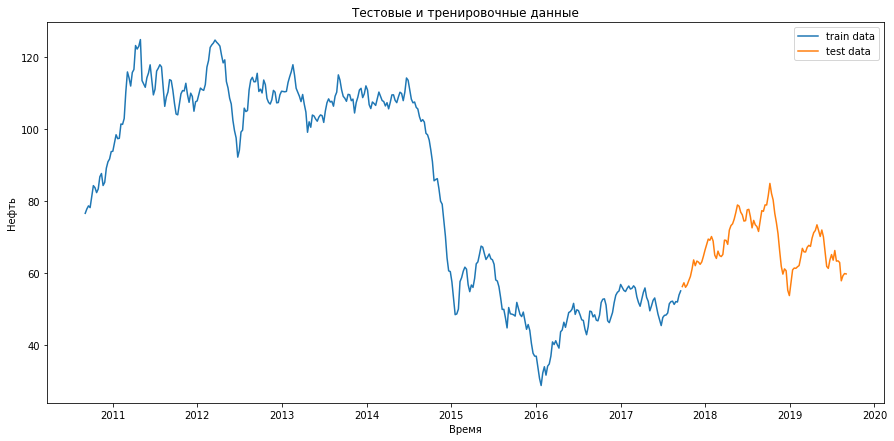

In [12]:
train, test = split_data( dfw, -100)
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Нефть')
plt.plot(train.index,train.iloc[:,0], label='train data' )
plt.plot(test.index,test.iloc[:,0], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [13]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

In [15]:
model_g = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_l = LinearRegression()

In [16]:
model_l.fit( X_train, y_train ) # 
model_g.fit( X_train, y_train ) 

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=15, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
y_test_pred_g = model_g.predict(X_test)
y_test_pred_l= model_l.predict(X_test)

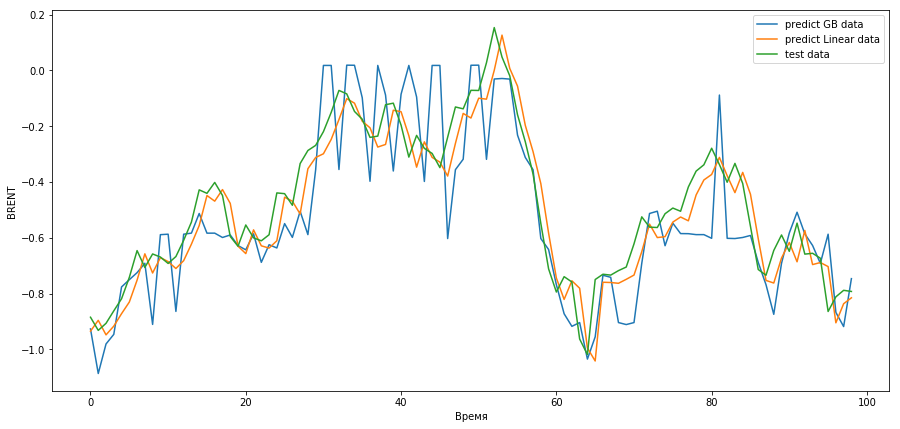

In [18]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_test_pred_g, label='predict GB data' )
plt.plot(y_test_pred_l, label='predict Linear data' )
plt.plot(y_test, label='test data')
plt.legend()
plt.show()

In [19]:
y_pred_g = model_g.predict(X_train)
y_pred_l= model_l.predict(X_train)

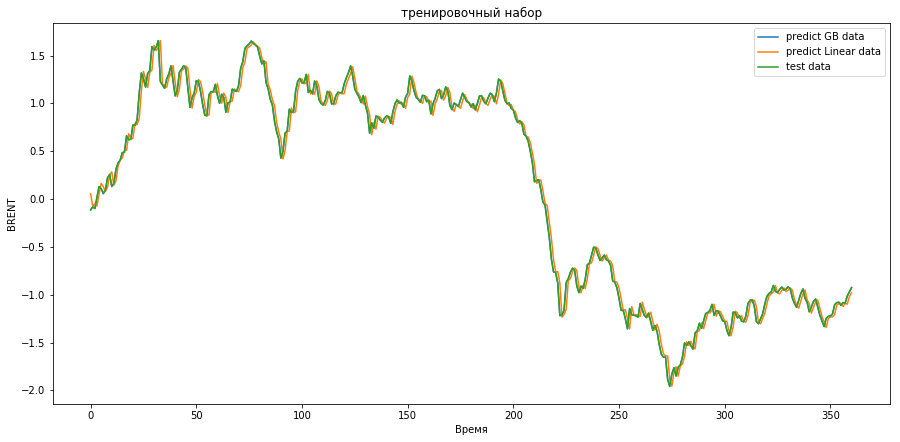

In [20]:
plt.figure( figsize=( 15, 7 ))

plt.title('тренировочный набор')
plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_pred_g, label='predict GB data' )
plt.plot(y_pred_l, label='predict Linear data' )
plt.plot(y_train, label='test data')

plt.legend()
plt.show()

In [21]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),
                                      y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   4.944966131951093 %


In [23]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,1,4,5], 
              "n_estimators":[100,200,300,400,500]}

#  randomized search
n_iter_search = 10
model_gr =GradientBoostingRegressor()
random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)
random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.631 (std: 0.193)
Parameters: {'n_estimators': 100, 'max_depth': 2}

Model with rank: 2
Mean validation score: 0.554 (std: 0.467)
Parameters: {'n_estimators': 500, 'max_depth': 1}

Model with rank: 3
Mean validation score: 0.530 (std: 0.453)
Parameters: {'n_estimators': 500, 'max_depth': 5}



In [24]:
model_g_best = GradientBoostingRegressor(max_depth=3,  n_estimators=300)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   4.2284697253293 %


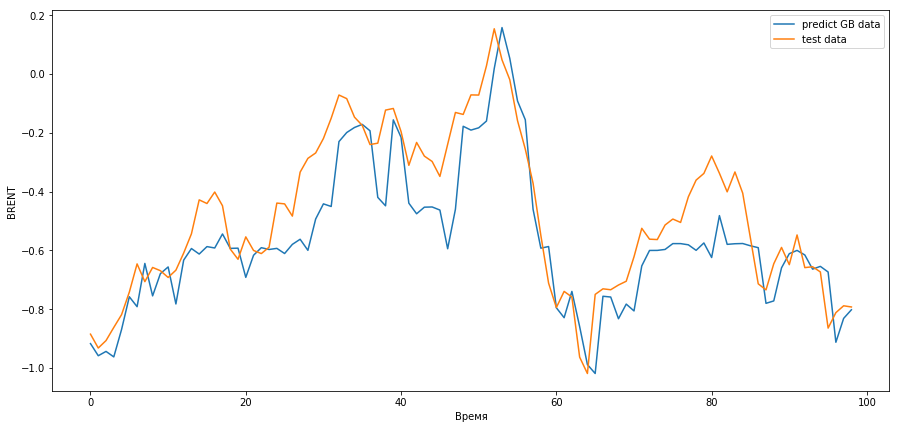

In [25]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_test_pred_g, label='predict GB data' )
plt.plot(y_test, label='test data')

plt.legend()
plt.show()

### 5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

Судя по всему ошибка уменьшается для варианта прогнозирование на основе обучения, т.е. такой вариант лучше чем вариант прямого прогнозирования